In [1]:
import sys
sys.path.append('../code/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from nilearn import datasets, plotting

from mamba_ssm import Mamba

import utils
from train_ann_sweep import get_generators
import pickle
from train_ann_sweep import get_generators

device = torch.device("cuda:0")
# device = torch.device("cpu")

In [2]:
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Loading atlas data stored in 'labels'
labels = atlas["labels"]

df = pd.read_pickle('../data/developmental_df.pkl')
n_subjects = len(np.unique(df['subj'].values))

time_series = df.iloc[:,:-1].values

# pca = PCA(n_components=39)
# points = pca.fit_transform(time_series)


In [3]:
with open('../data/mamba_bottleneck_sweep_results.pkl', 'rb') as f:
    metadata = pickle.load(f)
print(metadata['bottleneck_values'])

cv_dict = metadata['bottleneck_1']['fold_0']['metadata']['cv_dict']

[1, 3, 5, 7, 9, 11, 13, 15]


In [13]:
criterion = nn.MSELoss()

def get_ann_autoencoder_mse(training_set, validation_set, fold=0, bottleneck=15):
    with open('../data/ann_bottleneck_sweep_results.pkl', 'rb') as f:
        metadata = pickle.load(f)

    input_size = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['input_size']
    encoder_layer_size = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['encoder_layer_size']
    decoder_layer_size = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['decoder_layer_size']


    model = utils.model_ann_autoencoder(input_size, encoder_layer_size, decoder_layer_size, bottleneck=bottleneck).to(device)
    state_dict = torch.load(f'../models/ann/bottleneck/ann_fold{fold}_bottleneck{bottleneck}.pt')
    model.load_state_dict(state_dict)

    model.eval()
    with torch.no_grad():
        y_pred_train = model(training_set[:].float().to(device))[0].detach().cpu()
        y_pred_val = model(validation_set[:].float().to(device))[0].detach().cpu()

    return criterion(training_set[:], y_pred_train).numpy(), criterion(validation_set[:], y_pred_val).numpy(),


def get_mamba_autoencoder_mse(training_set, validation_set, fold=0, bottleneck=15):
    input_size = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['input_size']
    encoder_hidden = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['encoder_hidden']
    decoder_hidden = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['decoder_hidden']


    model = utils.model_mamba_autoencoder(input_size, encoder_hidden, decoder_hidden, bottleneck=bottleneck).to(device)
    state_dict = torch.load(f'../models/mamba/bottleneck/mamba_fold{fold}_bottleneck{bottleneck}.pt')
    model.load_state_dict(state_dict)

    model.eval()
    with torch.no_grad():
        y_pred_train = model(training_set[:].float().to(device))[0].detach().cpu()
        y_pred_val = model(validation_set[:].float().to(device))[0].detach().cpu()

    return criterion(training_set[:], y_pred_train).numpy(), criterion(validation_set[:], y_pred_val).numpy(),

   

def get_pca_mse(training_set, validation_set, fold=0, bottleneck=15):

    pca = PCA(n_components=bottleneck)
    batch_num, num_times, num_features = training_set[:].shape

    train_points = pca.fit_transform(training_set[:].numpy().reshape(-1, num_features))
    val_points = pca.transform(validation_set[:].numpy().reshape(-1, num_features))

    y_pred_train = torch.tensor(pca.inverse_transform(train_points).reshape(training_set[:].shape))
    y_pred_val = torch.tensor(pca.inverse_transform(val_points).reshape(validation_set[:].shape))

    return criterion(training_set[:], y_pred_train).numpy(), criterion(validation_set[:], y_pred_val).numpy()


    # explained_var = np.cumsum(pca.explained_variance_ratio_)
    # explained_var = np.concatenate([[0], explained_var])
    # thresh_pos = np.argmin(np.abs(explained_var - 0.8))




In [14]:
fold = 0
bottleneck = 15

In [15]:
bottleneck_values = metadata['bottleneck_values']
ann_train_loss_sweep, ann_val_loss_sweep = list(), list()
pca_train_loss_sweep, pca_val_loss_sweep = list(), list()

for bottleneck in bottleneck_values:
    print(f'running bottleneck {bottleneck}', end='\n')
    ann_train_loss_fold, ann_val_loss_fold = list(), list()
    pca_train_loss_fold, pca_val_loss_fold = list(), list()
    for fold in range(5):
        generators, data_arrays = get_generators(df, cv_dict, fold=fold)
        training_generator, _, validation_generator, _ = generators
        training_set, _, validation_set = data_arrays

        ann_train_loss, ann_val_loss = get_ann_autoencoder_mse(training_set, validation_set, fold=fold, bottleneck=bottleneck)
        # ann_train_loss, ann_val_loss = get_mamba_autoencoder_mse(training_set, validation_set, fold=fold, bottleneck=bottleneck)
        pca_train_loss, pca_val_loss = get_pca_mse(training_set, validation_set, fold=fold, bottleneck=bottleneck)

        ann_train_loss_fold.append(ann_train_loss)
        ann_val_loss_fold.append(ann_val_loss)
        pca_train_loss_fold.append(pca_train_loss)
        pca_val_loss_fold.append(pca_val_loss)

    ann_train_loss_sweep.append(ann_train_loss_fold)
    ann_val_loss_sweep.append(ann_val_loss_fold)
    pca_train_loss_sweep.append(pca_train_loss_fold)
    pca_val_loss_sweep.append(pca_val_loss_fold)

ann_train_loss_sweep = np.array(ann_train_loss_sweep)
ann_val_loss_sweep = np.array(ann_val_loss_sweep)
pca_train_loss_sweep = np.array(pca_train_loss_sweep)
pca_val_loss_sweep = np.array(pca_val_loss_sweep)




running bottleneck 1
running bottleneck 3
running bottleneck 5
running bottleneck 7
running bottleneck 9
running bottleneck 11
running bottleneck 13
running bottleneck 15


Text(0.5, 1.0, 'ANN vs PCA Train Loss')

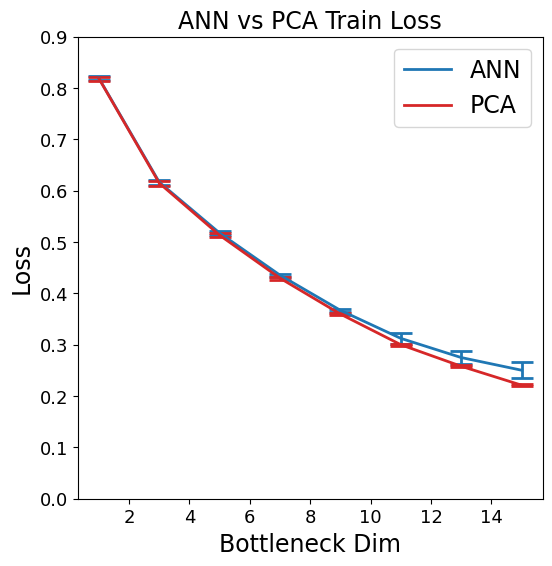

In [16]:
labelsize = 17
ticksize=13
capsize = 8
linewidth=2

ann_color = 'C0'
pca_color = 'C3'

plt.figure(figsize=(6,6))
plt.errorbar(x=bottleneck_values, y=np.mean(ann_train_loss_sweep, axis=1), yerr=np.std(ann_train_loss_sweep, axis=1),
             capsize=capsize, linewidth=linewidth, capthick=linewidth, color=ann_color)
plt.errorbar(x=bottleneck_values, y=np.mean(pca_train_loss_sweep, axis=1), yerr=np.std(pca_train_loss_sweep, axis=1),
             capsize=capsize, linewidth=linewidth, capthick=linewidth, color=pca_color)


plt.plot([], [], label='ANN', linewidth=linewidth, color=ann_color)
plt.plot([], [], label='PCA', linewidth=linewidth, color=pca_color)

plt.xlabel('Bottleneck Dim', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.ylabel('Loss', fontsize=labelsize)
plt.yticks(fontsize=ticksize)

plt.legend(fontsize=labelsize)
plt.ylim(0.0, 0.9)


plt.title('ANN vs PCA Train Loss', fontsize=labelsize)

Text(0.5, 1.0, 'ANN vs PCA Test Loss')

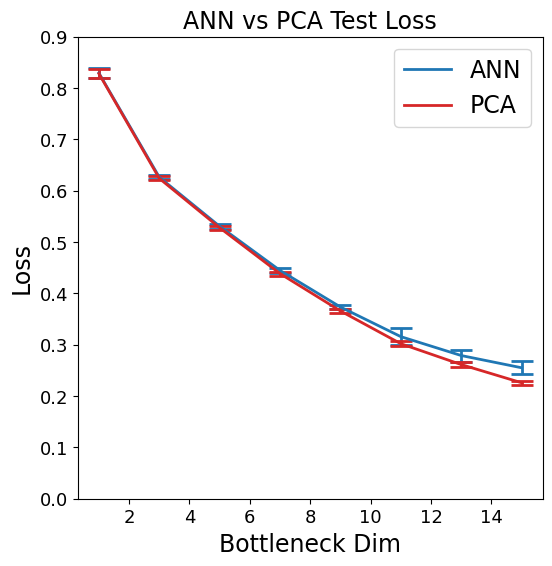

In [17]:
labelsize = 17
ticksize=13
capsize = 8
linewidth=2

ann_color = 'C0'
pca_color = 'C3'

plt.figure(figsize=(6,6))
plt.errorbar(x=bottleneck_values, y=np.mean(ann_val_loss_sweep, axis=1), yerr=np.std(ann_val_loss_sweep, axis=1),
             capsize=capsize, linewidth=linewidth, capthick=linewidth, color=ann_color)
plt.errorbar(x=bottleneck_values, y=np.mean(pca_val_loss_sweep, axis=1), yerr=np.std(pca_val_loss_sweep, axis=1),
             capsize=capsize, linewidth=linewidth, capthick=linewidth, color=pca_color)


plt.plot([], [], label='ANN', linewidth=linewidth, color=ann_color)
plt.plot([], [], label='PCA', linewidth=linewidth, color=pca_color)

plt.xlabel('Bottleneck Dim', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.ylabel('Loss', fontsize=labelsize)
plt.yticks(fontsize=ticksize)

plt.legend(fontsize=labelsize)
plt.ylim(0.0, 0.9)
plt.title('ANN vs PCA Test Loss', fontsize=labelsize)